# torch.nn.functional 사용하여 신경망 구축하기

In [2]:
import torch
from torch import nn
import math
import torch.nn.functional as F


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [3]:
model = Mnist_Logistic()


In [5]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'https://github.com/pytorch/tutorials/raw/master/_static/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,
encoding='latin-1')

(50000, 784)


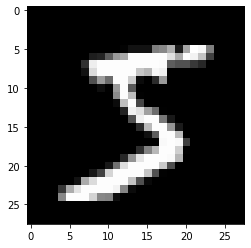

In [7]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape) ## 28x28 이미지가 펼쳐서 784 하나의 행으로 이루어진 것을 알 수 있음

In [8]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [12]:
bs = 64 # 배치 사이즈

xb = x_train[0:bs] # x로부터 미니배치 설정
preds = model(xb) # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

yb = y_train[0:bs]


tensor([ 0.3492,  0.4201, -0.3532,  0.1815, -0.0714, -0.1640, -0.3307,  0.1231,
        -0.1327, -0.5911], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [13]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [14]:
print(loss_func(model(xb), yb))

tensor(2.3757, grad_fn=<NllLossBackward0>)


In [16]:
epochs = 10
lr = 0.0001
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [17]:
print(loss_func(model(xb), yb))

tensor(1.7248, grad_fn=<NllLossBackward0>)


# nn.linear을 통해 weight와 bias 계산을 해줌

In [18]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [19]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3340, grad_fn=<NllLossBackward0>)


In [20]:
fit()

print(loss_func(model(xb), yb))

tensor(1.6810, grad_fn=<NllLossBackward0>)


# pytorch의 최적화 알고리즘은 torch.optim 패키지에 존재

In [23]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr = lr)

model, opt = get_model()
epochs = 50


print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(2.3680, grad_fn=<NllLossBackward0>)
tensor(1.3290, grad_fn=<NllLossBackward0>)


# Dataset을 사용해서 재구성하기


In [24]:

from torch.utils.data import TensorDataset

In [25]:
train_ds = TensorDataset(x_train, y_train)


In [26]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n -1) // bs + 1):
        xb, yb = train_ds[i * bs : i *bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(1.3446, grad_fn=<NllLossBackward0>)


# DataLoader를 사용하여 batch사이즈만큼 데이터 출력

In [27]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs)



In [28]:
model , opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()

        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(1.3182, grad_fn=<NllLossBackward0>)


# 검증 데이터 활용

In [31]:
train_ds =TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle= True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    model.train() ## model 학습할거다 선언 같은거
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval() ## model 평가할거다
    with torch.no_grad(): ## 역전파 안할거니까 메모리에 가중치 기록안해도대
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print("{} epoch : loss {}".format(epoch, valid_loss / len(valid_dl)))

0 epoch : loss 2.2519164085388184
1 epoch : loss 2.169987440109253
2 epoch : loss 2.0944440364837646
3 epoch : loss 2.0240797996520996
4 epoch : loss 1.958151936531067
5 epoch : loss 1.8961726427078247
6 epoch : loss 1.8377878665924072
7 epoch : loss 1.7827188968658447
8 epoch : loss 1.7307720184326172
9 epoch : loss 1.6817128658294678
10 epoch : loss 1.6353696584701538
11 epoch : loss 1.5916073322296143
12 epoch : loss 1.5502383708953857
13 epoch : loss 1.5111238956451416
14 epoch : loss 1.4741274118423462
15 epoch : loss 1.4391095638275146
16 epoch : loss 1.405942678451538
17 epoch : loss 1.3745113611221313
18 epoch : loss 1.3447117805480957
19 epoch : loss 1.3164241313934326
20 epoch : loss 1.289560317993164
21 epoch : loss 1.2640371322631836
22 epoch : loss 1.2397592067718506
23 epoch : loss 1.2166399955749512
24 epoch : loss 1.1946154832839966
25 epoch : loss 1.1736127138137817
26 epoch : loss 1.153568148612976
27 epoch : loss 1.134425401687622
28 epoch : loss 1.1161283254623413
2

# fit(), get_data() 생성하여 loss를 두번이나 계산하는 부분 정리, 간결한 코드 작성

In [45]:
def loss_batch(model, loss_func, xb, yb, opt=None): ## 검증 셋에 대해서는 opt를 전달하지 않는다
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [46]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()

        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print("{} epoch, val loss : {}".format(epoch, val_loss))    


In [47]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle= True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

In [48]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 epoch, val loss : 2.187267266845703
1 epoch, val loss : 2.109177949142456
2 epoch, val loss : 2.0372276927948
3 epoch, val loss : 1.9701565540313721
4 epoch, val loss : 1.9072999883651733
5 epoch, val loss : 1.8481884267807007
6 epoch, val loss : 1.792496614265442
7 epoch, val loss : 1.7399691598892213
8 epoch, val loss : 1.6904027557373047
9 epoch, val loss : 1.64359280128479
10 epoch, val loss : 1.5993885486602784
11 epoch, val loss : 1.5576306970596314
12 epoch, val loss : 1.518146385574341
13 epoch, val loss : 1.4808191974639893
14 epoch, val loss : 1.4454995399475097
15 epoch, val loss : 1.4120672706604005
16 epoch, val loss : 1.3803984497070312
17 epoch, val loss : 1.3503790031433105
18 epoch, val loss : 1.3218984251022339
19 epoch, val loss : 1.2948610855102538
20 epoch, val loss : 1.2691765243530273
21 epoch, val loss : 1.244750577735901
22 epoch, val loss : 1.221509676361084
23 epoch, val loss : 1.199377431678772
24 epoch, val loss : 1.1782799522399903
25 epoch, val loss : 1